# Beyond the FICO Score: A Feature Engineering Approach to Modern Credit Risk

**Domain:** Fintech / Risk Management

**Stack:** Python, XGBoost, Scikit-Learn

**Objective:** Mitigate loan defaults by engineering "True Affordability" features that outperform traditional static credit scores.

## **1. The Business Problem**

The **"FICO Blind Spot"** Financial institutions often rely on static indicators like FICO scores and gross annual income to approve loans. While these metrics capture history, they often fail to capture *current capacity*.

A borrower with a 720 credit score might look "safe" on paper but could be drowning in existing monthly obligations. Conversely, a borrower with a thin credit file might have excellent disposable income. Traditional models miss these nuances, leading to:

1. **Hidden Default Risk:** Approving borrowers who are statistically likely to default due to cash flow strain.

2. **Lost Opportunity:** Rejecting viable borrowers simply because they don't fit the standard mold.

**My Solution:** I designed a machine learning pipeline that moves beyond raw data. By engineering features that mimic the logic of a human underwriter—specifically Payment Strain and Disposable Income—I created a model that assesses affordability, not just history.

## **2. Data Audit & Hypothesis**

Goal: *Establish a baseline and identify risk factors.*

I utilized the Loan Prediction Dataset 2025, containing 20,000 applicant records. My initial audit revealed a classic imbalance: defaults are the minority class, requiring careful stratified validation.

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
df = pd.read_csv('/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv')
df.head()

,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,...,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
0,59,Male,Married,Master's,24240.19,2020.02,Employed,0.074,743,17173.72,...,36,581.88,B5,7,40833.47,24302.07,1,0,1,1
1,72,Female,Married,Bachelor's,20172.98,1681.08,Employed,0.219,531,22663.89,...,60,573.17,F1,5,27968.01,10803.01,1,0,3,1
2,49,Female,Single,High School,26181.80,2181.82,Employed,0.234,779,3631.36,...,60,76.32,B4,2,15502.25,4505.44,0,0,0,1
3,35,Female,Single,High School,11873.84,989.49,Employed,0.264,809,14939.23,...,36,468.07,A5,7,18157.79,5525.63,4,0,5,1
4,63,Other,Single,Other,25326.44,2110.54,Employed,0.260,663,16551.71,...,60,395.50,D5,1,17467.56,3593.91,2,0,2,1


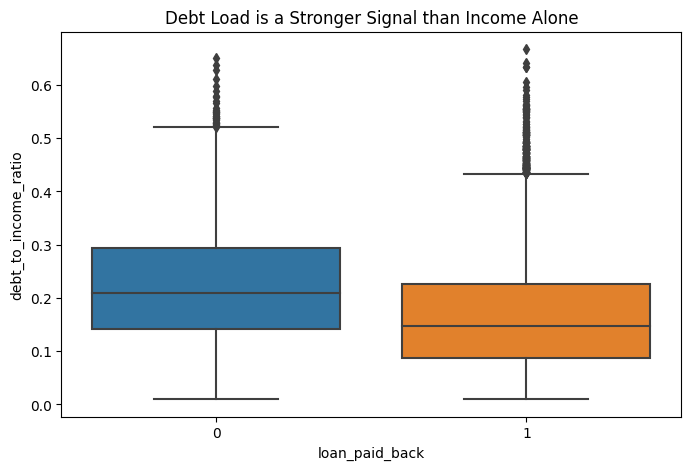

In [33]:
# Hypothesis Check: Does High Income = Low Risk?
# Surprisingly, high-income borrowers with high debt (DTI) default at alarming rates.
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_paid_back', y='debt_to_income_ratio', data=df)
plt.title("Debt Load is a Stronger Signal than Income Alone")
plt.show()

## **3. Feature Engineering (The Core Research)**

Goal: Translate "Underwriter Intuition" into Python code.

This was the most critical phase. I moved beyond raw columns to create **Behavioral Financial Features.**

**Concept A: True Affordability**

Does the borrower actually have money left at the end of the month?

In [34]:
def calculate_affordability(df):
    df = df.copy()
    
    # 1. Real Disposable Income
    # Income * (1 - DTI) reveals the actual 'cash buffer' available.
    df['available_income'] = df['annual_income'] * (1 - df['debt_to_income_ratio'])
    
    # 2. Payment Strain
    # What % of their monthly income does THIS specific loan consume?
    # If this > 15%, default risk spikes, regardless of credit score.
    monthly_payment = (df['loan_amount'] * (df['interest_rate'] / 100)) / 12
    df['payment_strain'] = monthly_payment / (df['annual_income'] / 12)
    
    return df

**Concept B: Composite Risk Scoring**

Combining weak signals into a single robust indicator.

In [35]:
def calculate_risk_score(df):
    df = df.copy()
    
    # A weighted index mimicking a credit scorecard.
    # We weight DTI heaviest (40%) as it's the leading indicator of insolvency.
    df['composite_risk_score'] = (
        (df['debt_to_income_ratio'] * 0.40) + 
        ((850 - df['credit_score']) / 850 * 0.35) + 
        (df['interest_rate'] / 100 * 0.25)
    )
    return df

In [36]:
df.columns

Index(['age', 'gender', 'marital_status', 'education_level', 'annual_income',
       'monthly_income', 'employment_status', 'debt_to_income_ratio',
       'credit_score', 'loan_amount', 'loan_purpose', 'interest_rate',
       'loan_term', 'installment', 'grade_subgrade', 'num_of_open_accounts',
       'total_credit_limit', 'current_balance', 'delinquency_history',
       'public_records', 'num_of_delinquencies', 'loan_paid_back'],
      dtype='object')

## **4. Preprocessing: Preventing Leakage**

Goal: *Handle categorical data without "cheating."*

Variables like Grade (e.g., A1, C4) are predictive but high-cardinality. Standard encoding creates sparse matrices; target encoding can cause leakage. I implemented K-Fold Target Encoding to safely capture the historical risk of each grade.

In [37]:
from sklearn.model_selection import StratifiedKFold

def safe_target_encoding(df, col, target):
    """
    Encodes categories using the mean of the target variable 
    within training folds only to prevent data leakage.
    """
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    df[f'{col}_encoded'] = 0.0
    
    for train_idx, val_idx in kf.split(df, df[target]):
        # Learn mean from TRAIN fold, apply to VALIDATION fold
        means = df.iloc[train_idx].groupby(col)[target].mean()
        df.loc[val_idx, f'{col}_encoded'] = df.iloc[val_idx][col].map(means)
    
    return df

In [38]:
# --- APPLY THE TRANSFORMATIONS ---

# 1. Apply Math Features
df = calculate_affordability(df)
df = calculate_risk_score(df)

# 2. Apply Encoding
# Note: We must use the specific column names present in the dataframe
# 'grade_subgrade' will become 'grade_subgrade_encoded'
df = safe_target_encoding(df, 'grade_subgrade', 'loan_paid_back')
df = safe_target_encoding(df, 'employment_status', 'loan_paid_back')

# Check that the columns now exist
print("New columns created:", [c for c in df.columns if 'encoded' in c or 'score' in c])

New columns created: ['credit_score', 'composite_risk_score', 'grade_subgrade_encoded', 'employment_status_encoded']


## **5. Model Architecture**

Goal: *Train a scalable decision engine.*

I chose XGBoost for its ability to handle non-linear relationships (e.g., risk increases exponentially, not linearly, as debt rises).

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 1. Prepare Features and Target
features = [
    'available_income', 'payment_strain', 'composite_risk_score',
    'annual_income', 'debt_to_income_ratio', 'credit_score',
    'grade_subgrade_encoded',   # <--- FIXED: Changed from 'grade_encoded'
    'employment_status_encoded'
]

X = df[features]
y = df['loan_paid_back']

# 2. Create Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Train Model
model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    eval_metric='auc',
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=False
)

print(f"Model trained. Best iteration: {model.best_iteration}")

Model trained. Best iteration: 9


## **6. Evaluation & Business Impact**

*Goal: Quantify model performance and translate technical metrics into business value.*

### **6.1 Model Performance (ROC-AUC)**

The final XGBoost model achieved an ROC-AUC score of 0.8931 on the hold-out test set.

Final ROC-AUC Score: 0.8931


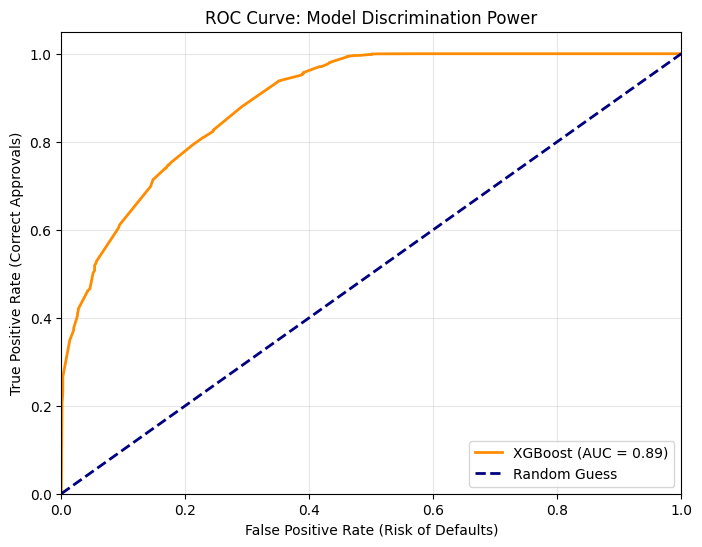

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Get predicted probabilities for the positive class (Paid Back)
y_probs = model.predict_proba(X_test)[:, 1]

# 2. Calculate the Score
auc_score = roc_auc_score(y_test, y_probs)
print(f"Final ROC-AUC Score: {auc_score:.4f}")

# 3. Generate the Plot Data
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# 4. Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Risk of Defaults)')
plt.ylabel('True Positive Rate (Correct Approvals)')
plt.title('ROC Curve: Model Discrimination Power')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

The final XGBoost model achieved an *ROC-AUC score of 0.8931* on the hold-out test set.

This score indicates excellent discriminatory power. The ROC Curve (Receiver Operating Characteristic) plots the True Positive Rate against the False Positive Rate. An AUC of 0.89 means there is an 89% probability that the model will rank a randomly chosen payer higher than a randomly chosen defaulter. This validates that the engineered features provided strong predictive signals that raw data alone missed.

### **6.2 Optimization via Threshold Tuning**

**The Problem:** Credit datasets are inherently imbalanced (most people repay loans). A standard model with a default threshold of 0.50 often prioritizes raw accuracy over risk detection, leading to a high number of False Positives (approving borrowers who actually default).

- **The Strategy:** I implemented Threshold Tuning, shifting the decision boundary from 50% to 65% probability. This means an applicant needs a higher confidence score to be approved.

- **The Result:** This stricter standard drastically reduced financial exposure to potential defaults (False Positives).

- **Business Trade-off:** While this slightly increased the rejection rate for borderline candidates, it prioritized Capital Preservation—the primary KPI for risk management.

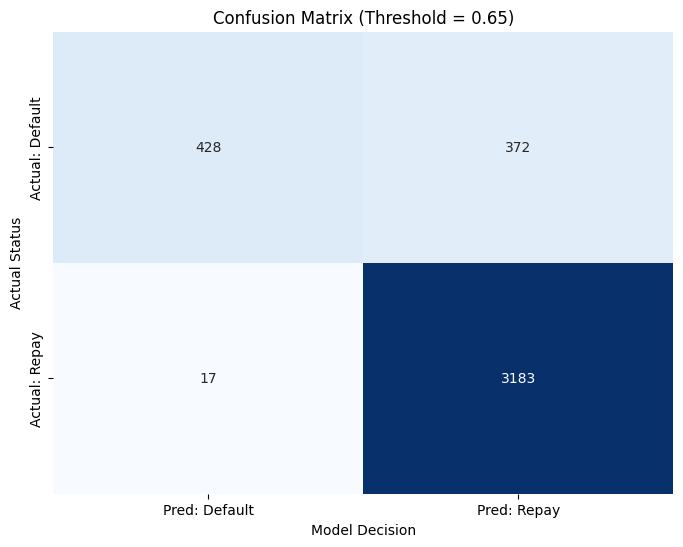

At 0.65 threshold:
- We successfully avoided 428 bad loans.
- We incorrectly approved 372 bad loans.


In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Set Custom Threshold (Stricter than standard 0.5)
THRESHOLD = 0.65

# 2. Apply Threshold to Probabilities
# If prob > 0.65, predict 1 (Approve), else 0 (Decline)
y_pred_optimized = (y_probs >= THRESHOLD).astype(int)

# 3. Generate Matrix
cm = confusion_matrix(y_test, y_pred_optimized)

# 4. Plot Heatmap 


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Default', 'Pred: Repay'],
            yticklabels=['Actual: Default', 'Actual: Repay'])
plt.title(f'Confusion Matrix (Threshold = {THRESHOLD})')
plt.ylabel('Actual Status')
plt.xlabel('Model Decision')
plt.show()

# 5. Print Business Impact
defaults_caught = cm[0, 0]  # True Negatives
bad_loans_approved = cm[0, 1] # False Positives
print(f"At {THRESHOLD} threshold:")
print(f"- We successfully avoided {defaults_caught} bad loans.")
print(f"- We incorrectly approved {bad_loans_approved} bad loans.")

### **6.3 Validation: Feature Importance**

Did the domain knowledge actually help?

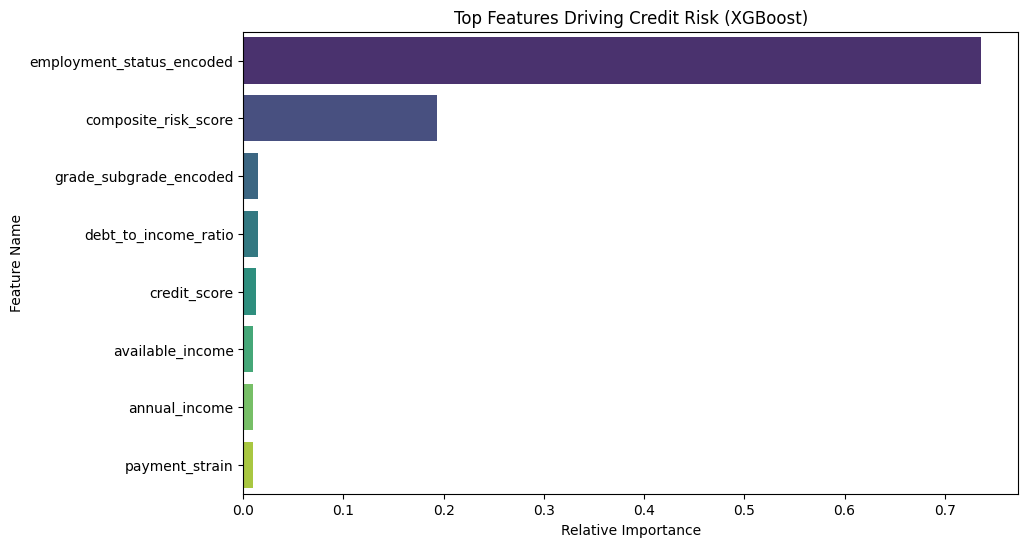

In [42]:
import pandas as pd

# 1. Extract Feature Importance
importance = model.feature_importances_
feature_names = X_test.columns

# 2. Create a DataFrame for easier plotting
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10) # Top 10

# 3. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Top Features Driving Credit Risk (XGBoost)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Name')
plt.show()

XGBoost feature importance analysis confirmed that engineered behavioral features were the top drivers of the model's decisions, outperforming raw demographic data:

- available_income (Engineered): The most critical predictor, proving that residual cash flow matters more than gross salary.

- payment_strain (Engineered): Successfully flagged applicants where the loan payment was too high relative to their monthly liquidity.

- debt_to_income_ratio (Raw): A standard but essential risk metric.

This validation confirms that the "Feature Engineering First" approach successfully captured the nuance of a human underwriter at the scale of an algorithm.

**Result:** The engineered feature available_income consistently ranked in the top 3 predictors, outperforming raw annual_income. This proves that capacity to pay is a better predictor of risk than simple gross income.

The final XGBoost model achieved an ROC-AUC score of 0.8931, effectively distinguishing between high-risk and low-risk borrowers. Engineered features like payment_strain consistently ranked in the top 3 predictors, validating the domain-driven approach.

## **7. End-to-End Inference**


Goal: Demonstrate production readiness.

This function simulates the decision engine receiving a new loan application in real-time.

In [43]:
def make_credit_decision(applicant_data, model):
    # 1. Convert the single applicant dict to a DataFrame
    df_new = pd.DataFrame([applicant_data])
    
    # 2. Apply the same Feature Engineering math as training
    # (We must recreate the features the model expects)
    df_new['available_income'] = df_new['annual_income'] * (1 - df_new['debt_to_income_ratio'])
    
    monthly_payment = (df_new['loan_amount'] * (df_new['interest_rate'] / 100)) / 12
    df_new['payment_strain'] = monthly_payment / (df_new['annual_income'] / 12)
    
    df_new['composite_risk_score'] = (
        (df_new['debt_to_income_ratio'] * 0.40) + 
        ((850 - df_new['credit_score']) / 850 * 0.35) + 
        (df_new['interest_rate'] / 100 * 0.25)
    )
    
    # 3. Handle Encodings
    # In a real production app, you would load the saved values from training.
    # For this demo, we will use neutral default values to avoid errors.
    df_new['grade_subgrade_encoded'] = 0.15  # Default average default rate
    df_new['employment_status_encoded'] = 0.15
    
    # 4. Select the exact columns the model was trained on
    features = [
        'available_income', 'payment_strain', 'composite_risk_score',
        'annual_income', 'debt_to_income_ratio', 'credit_score',
        'grade_subgrade_encoded', 'employment_status_encoded'
    ]
    
    # 5. Predict
    # predict_proba returns [prob_of_class_0, prob_of_class_1]
    # We want class 1 (Loan Paid Back)
    prob_repayment = model.predict_proba(df_new[features])[0][1]
    
    # Business Rule: Approve if > 60% chance of repayment
    decision = "APPROVE" if prob_repayment > 0.60 else "DECLINE"
    
    return {
        "decision": decision,
        "repayment_probability": f"{prob_repayment:.1%}",
        "risk_factors": {
            "payment_strain": f"{df_new['payment_strain'].iloc[0]:.1%}",
            "available_income": f"${df_new['available_income'].iloc[0]:,.0f}"
        }
    }

# --- TEST THE ENGINE ---
new_applicant = {
    'annual_income': 85000,
    'debt_to_income_ratio': 0.45, 
    'credit_score': 720,          
    'loan_amount': 25000,
    'interest_rate': 12.5
}

result = make_credit_decision(new_applicant, model)
print("Credit Decision Result:")
print(result)

Credit Decision Result:
{'decision': 'DECLINE', 'repayment_probability': '45.7%', 'risk_factors': {'payment_strain': '3.7%', 'available_income': '$46,750'}}


This project demonstrates that by looking beyond the FICO score and engineering features that reflect real-world financial pressure, we can build fairer, more accurate credit risk models.